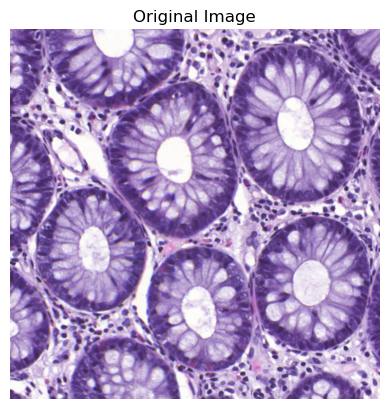

C:\Users\ilayd\AppData\Local\Temp\ipykernel_26172\1191630247.py:15: RuntimeWarning: invalid value encountered in divide
  hsv_image[:, :, 0][mask_r] = (60 * (image[:, :, 1] - image[:, :, 2]) / diff_rgb + 360)[mask_r] % 360
C:\Users\ilayd\AppData\Local\Temp\ipykernel_26172\1191630247.py:17: RuntimeWarning: invalid value encountered in divide
  hsv_image[:, :, 0][mask_g] = (60 * (image[:, :, 2] - image[:, :, 0]) / diff_rgb + 120)[mask_g] % 360
C:\Users\ilayd\AppData\Local\Temp\ipykernel_26172\1191630247.py:19: RuntimeWarning: invalid value encountered in divide
  hsv_image[:, :, 0][mask_b] = (60 * (image[:, :, 0] - image[:, :, 1]) / diff_rgb + 240)[mask_b] % 360
C:\Users\ilayd\AppData\Local\Temp\ipykernel_26172\1191630247.py:30: RuntimeWarning: invalid value encountered in cast
  return hsv_image.astype(np.uint8)


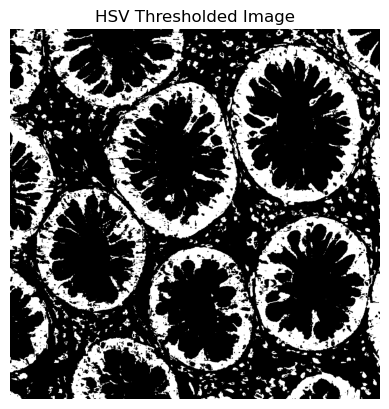

In [4]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Convert RGB image to HSV
def rgb_to_hsv(image):
    image = image / 255.0  # Normalize the image
    hsv_image = np.zeros_like(image)
    max_rgb = image.max(axis=2)
    min_rgb = image.min(axis=2)
    diff_rgb = max_rgb - min_rgb

    # Hue calculation
    mask_r = (max_rgb == image[:, :, 0])
    hsv_image[:, :, 0][mask_r] = (60 * (image[:, :, 1] - image[:, :, 2]) / diff_rgb + 360)[mask_r] % 360
    mask_g = (max_rgb == image[:, :, 1])
    hsv_image[:, :, 0][mask_g] = (60 * (image[:, :, 2] - image[:, :, 0]) / diff_rgb + 120)[mask_g] % 360
    mask_b = (max_rgb == image[:, :, 2])
    hsv_image[:, :, 0][mask_b] = (60 * (image[:, :, 0] - image[:, :, 1]) / diff_rgb + 240)[mask_b] % 360

    # Saturation calculation
    hsv_image[:, :, 1] = np.where(max_rgb == 0, 0, (diff_rgb / max_rgb))

    # Value calculation
    hsv_image[:, :, 2] = max_rgb

    hsv_image[:, :, 0] = hsv_image[:, :, 0] / 2  # Scale hue to 0-180
    hsv_image[:, :, 1] = hsv_image[:, :, 1] * 255  # Scale saturation to 0-255
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * 255  # Scale value to 0-255
    return hsv_image.astype(np.uint8)

# Apply HSV threshold
def apply_hsv_threshold(hsv_image, h_min, s_min, v_min, h_max, s_max, v_max):
    mask = ((hsv_image[:, :, 0] >= h_min) & (hsv_image[:, :, 0] <= h_max) &
            (hsv_image[:, :, 1] >= s_min) & (hsv_image[:, :, 1] <= s_max) &
            (hsv_image[:, :, 2] >= v_min) & (hsv_image[:, :, 2] <= v_max))
    binary_image = np.zeros_like(hsv_image[:, :, 0])
    binary_image[mask] = 255
    return binary_image

# Load the image
def load_image(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    return img

# Plot the image
def plot_image(image, title):
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

image_path = 'T07-00439_p211.png'  

image = load_image(image_path)
plot_image(image, 'Original Image')

# Convert to HSV and apply the threshold
hsv_image = rgb_to_hsv(image)
binary_image = apply_hsv_threshold(hsv_image, h_min=129, s_min=100, v_min=100, h_max=142, s_max=202, v_max=175)

plot_image(binary_image, 'HSV Thresholded Image')


# COUNTING THE SEPARATE CELLS METHOD 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def load_binary_image(image_path):
    img = Image.open(image_path).convert('L')  
    binary_image = np.array(img)
    binary_image[binary_image > 0] = 255  # binary format (0 or 255)
    return binary_image

# Connected component labeling (Flood fill algorithm)
def connected_components(binary_image, min_size=100):
    visited = np.zeros_like(binary_image, dtype=bool)
    rows, cols = binary_image.shape
    cell_count = 0
    detected_cells = []

    def flood_fill(x, y):
        stack = [(x, y)]
        component = []

        while stack:
            cx, cy = stack.pop()
            if (0 <= cx < rows and 0 <= cy < cols and
                    binary_image[cx, cy] == 255 and not visited[cx, cy]):
                visited[cx, cy] = True
                component.append((cx, cy))

                # Check the 8 neighboring pixels
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx != 0 or dy != 0:
                            stack.append((cx + dx, cy + dy))

        return component

    # Iterate over the image to find components
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 255 and not visited[i, j]:
                component = flood_fill(i, j)
                if len(component) >= min_size:  # Only keep larger components
                    cell_count += 1
                    detected_cells.append(component)

    return cell_count, detected_cells


def highlight_cells(binary_image, detected_cells):
    color_image = np.stack([binary_image] * 3, axis=-1)  # Convert to RGB
    for component in detected_cells:
        for (x, y) in component:
            color_image[x, y] = [255, 0, 0]  # Highlight in red
    return color_image


def plot_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()



plot_image(binary_image, 'Binary Image for Cell Counting')


min_size_threshold = 1500

# Count cells and get detected cell coordinates with a size filter
cell_count, detected_cells = connected_components(binary_image, min_size=min_size_threshold)


highlighted_image = highlight_cells(binary_image, detected_cells)
plot_image(highlighted_image, 'Detected Cells Highlighted')

print(f'Total cells detected (size >= {min_size_threshold} pixels): {cell_count}')



NameError: name 'binary_image' is not defined

# MORPHOLOGICAL CLOSING

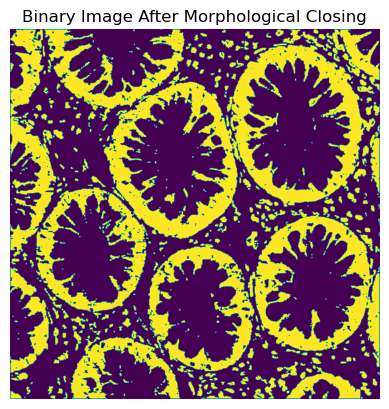

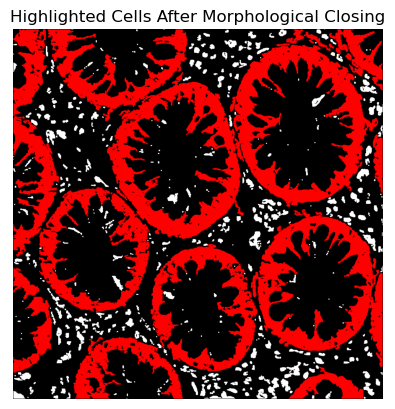

Total cells detected (size >= 1500 pixels): 12


In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def dilate(binary_image, kernel_size=3):
  """
  Perform dilation on the binary image.
  Expands the white regions (255) by a specified kernel size.
  """
  rows, cols = binary_image.shape
  padding = kernel_size // 2
  dilated_image = np.zeros_like(binary_image)

  for i in range(padding, rows - padding):
      for j in range(padding, cols - padding):
          # Check if any pixel in the kernel neighborhood is white
          if np.any(binary_image[i-padding:i+padding+1, j-padding:j+padding+1] == 255):
              dilated_image[i, j] = 255

  return dilated_image


def erode(binary_image, kernel_size=3):
    """
    Perform erosion on the binary image.
    Shrinks the white regions (255) by a specified kernel size.
    """
    rows, cols = binary_image.shape
    padding = kernel_size // 2
    eroded_image = np.zeros_like(binary_image)

    for i in range(padding, rows - padding):
        for j in range(padding, cols - padding):
            # Check if all pixels in the kernel neighborhood are white
            if np.all(binary_image[i-padding:i+padding+1, j-padding:j+padding+1] == 255):
                eroded_image[i, j] = 255

    return eroded_image


def morphological_closing(binary_image, kernel_size=3):
    """
    Perform morphological closing: dilation followed by erosion.
    """
    dilated_image = dilate(binary_image, kernel_size=3)
    closed_image = erode(dilated_image, kernel_size=3)
    return dilated_image



kernel_size = 3  
closed_image = morphological_closing(binary_image, kernel_size=kernel_size)




plot_image(closed_image, "Binary Image After Morphological Closing")



cell_count, detected_cells = connected_components(closed_image, min_size=min_size_threshold)

highlighted_image = highlight_cells(closed_image, detected_cells)
plot_image(highlighted_image, "Highlighted Cells After Morphological Closing")

print(f"Total cells detected (size >= {min_size_threshold} pixels): {cell_count}")

# ISOLATING THE DETECTED CELLS WITH A MASK

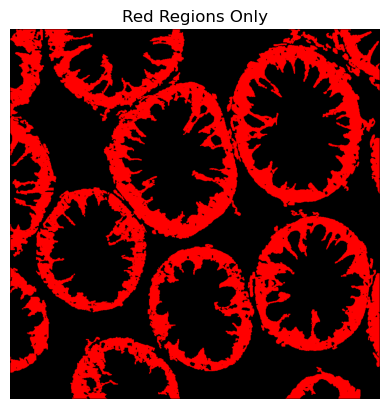

In [7]:
# Mask

# Create a mask for the red regions
def create_red_mask(image_shape, detected_cells):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)  
    for component in detected_cells:
        for x, y in component:
            mask[x, y] = 255  
    return mask


def isolate_red_regions(original_image, mask):
    color_image = np.zeros_like(original_image) 
    red_color = [255, 0, 0]  
    for i in range(3):  
        color_image[:, :, i] = mask if i == 0 else 0  
    return color_image


# Generate mask and isolate red regions
red_mask = create_red_mask(image.shape, detected_cells)
red_regions_image = isolate_red_regions(image, red_mask)

plt.imshow(red_regions_image)
plt.title('Red Regions Only')
plt.axis('off')
plt.show()

output_image = Image.fromarray(red_regions_image)
output_image.save("red_regions_isolated.png")

# AFTER THIS POINT, EXTERNAL LIBRARIES ARE USED FOR EXPERIMENTING

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "red_regions_isolated.png"  
res_masked_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

gray = cv2.cvtColor(res_masked_image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

binary = cv2.bitwise_not(binary)

# Perform a distance transform 
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

dist_transform = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


plt.figure(figsize=(6, 6))
plt.imshow(dist_transform, cmap='gray')
plt.title("Distance Transform")
plt.axis("off")
plt.show()

_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(binary, kernel, iterations=2)  
sure_bg = cv2.erode(sure_bg, kernel, iterations=1)  

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sure_bg, cmap='gray')
plt.title("Sure Background")
plt.axis("off")
plt.show()

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  
markers[unknown == 255] = 0  

markers = cv2.watershed(res_masked_image, markers)
segmented_image = res_masked_image.copy()
segmented_image[markers == -1] = [255, 0, 0]  

cell_count = len(np.unique(markers)) - 2

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f"Watershed Segmentation (Cell Count: {cell_count})")
plt.axis("off")
plt.show()

print(f"Cell count: {cell_count}")


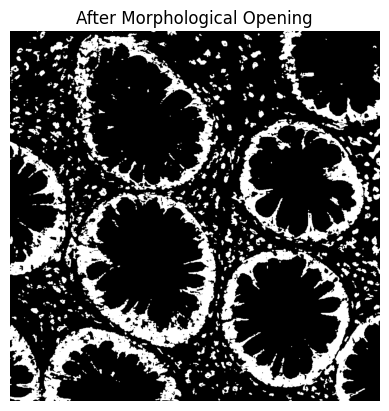

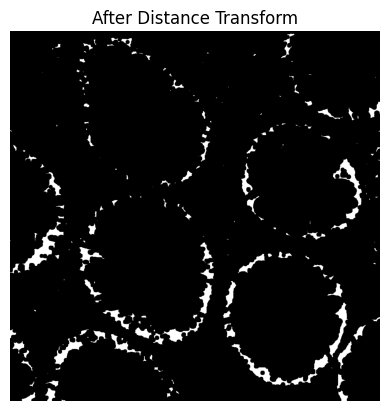

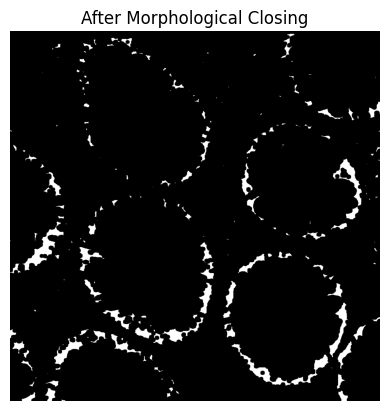

In [ ]:
import cv2

def apply_morphology(binary_image):
    
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open)

    distance_transform = cv2.distanceTransform(opened_image, cv2.DIST_L2, 5)
    _, distance_binary = cv2.threshold(distance_transform, 0.3 * distance_transform.max(), 255, cv2.THRESH_BINARY)
    distance_binary = distance_binary.astype(np.uint8)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))  
    closed_image = cv2.morphologyEx(distance_binary, cv2.MORPH_CLOSE, kernel_close)

    return opened_image, distance_binary, closed_image


opened_image, distance_binary, closed_image = apply_morphology(binary_image)

plot_image(opened_image, 'After Morphological Opening')
plot_image(distance_binary, 'After Distance Transform')
plot_image(closed_image, 'After Morphological Closing')

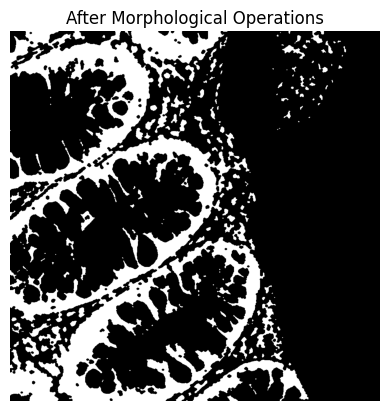

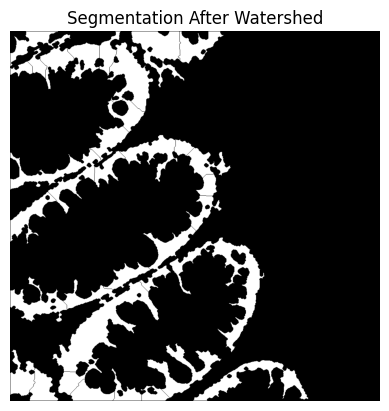

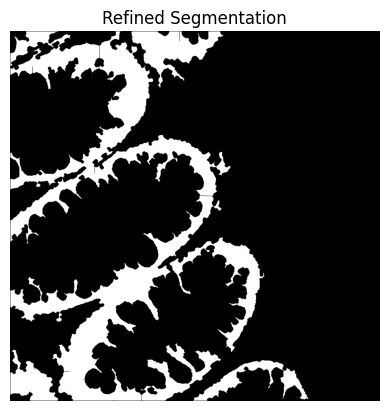

Number of cells detected: 6


In [ ]:

def apply_morphology(binary_image):

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel_close)

    return closed_image

def fix_segmentation(binary_image):
    distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(distance_transform, 0.5 * distance_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    sure_bg = cv2.dilate(binary_image, kernel, iterations=2)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    binary_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(binary_rgb, markers)
    final_segmentation = np.zeros_like(binary_image)
    final_segmentation[markers > 1] = 255

    return final_segmentation

def merge_small_regions(final_segmentation, min_area=20):
    contours, _ = cv2.findContours(final_segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_segmentation = np.zeros_like(final_segmentation)

    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(filtered_segmentation, [contour], -1, 255, thickness=-1)

    return filtered_segmentation

# Count the cells
def count_cells(segmentation):
    num_labels, _ = cv2.connectedComponents(segmentation)
    return num_labels - 1



morph_image = apply_morphology(binary_image)
plot_image(morph_image, 'After Morphological Operations')
segmentation = fix_segmentation(morph_image)
plot_image(segmentation, 'Segmentation After Watershed')
refined_segmentation = merge_small_regions(segmentation, min_area=50)
plot_image(refined_segmentation, 'Refined Segmentation')
cell_count = count_cells(refined_segmentation)
print(f"Number of cells detected: {cell_count}")

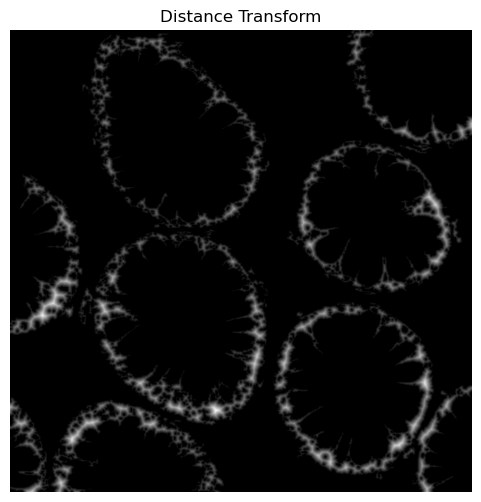

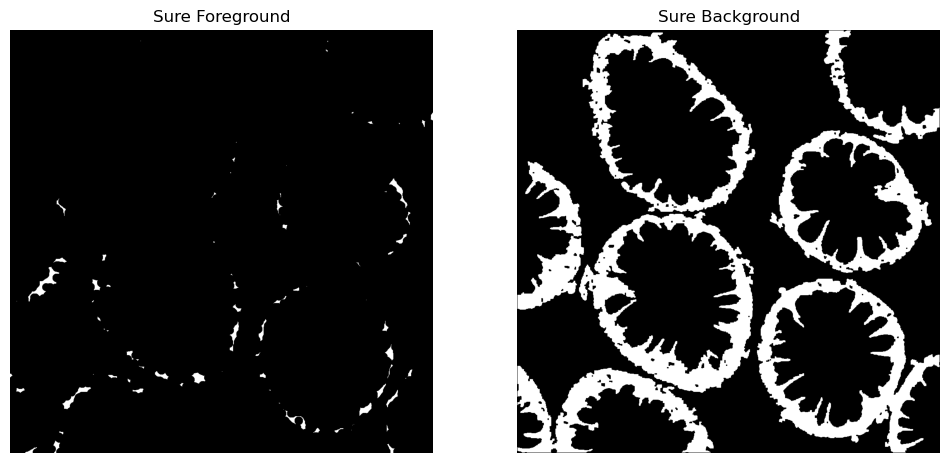

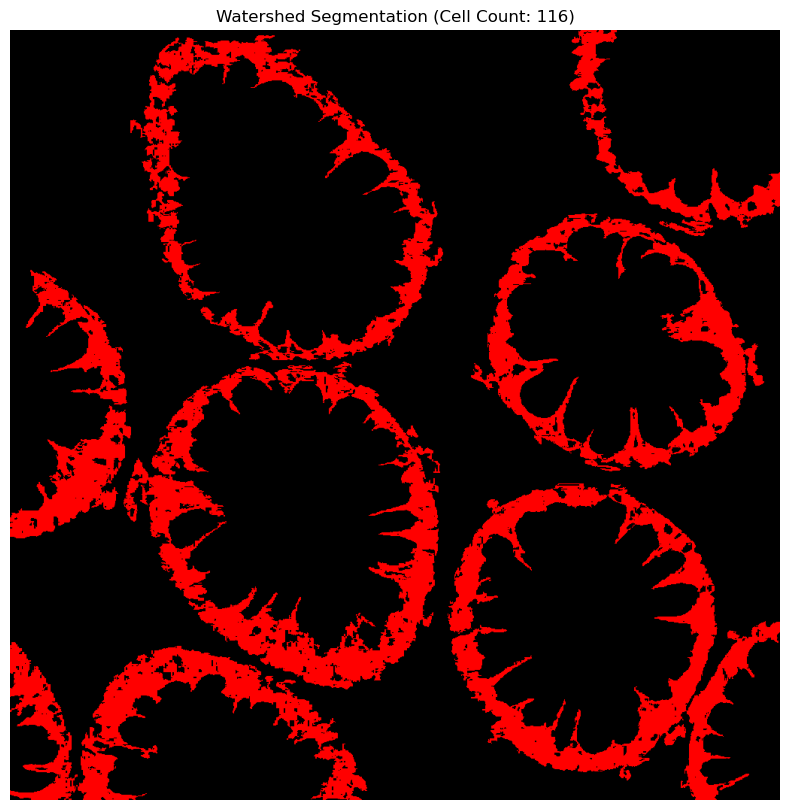

Cell count: 116


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, label, binary_dilation, binary_erosion


image_path = "red_regions_isolated.png" 
res_masked_image = plt.imread(image_path)[:, :, :3] 
res_masked_image = (res_masked_image * 255).astype(np.uint8)  

gray = np.dot(res_masked_image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

binary = (gray < 50).astype(np.uint8) * 255 

binary = 255 - binary

dist_transform = distance_transform_edt(binary)

dist_transform_normalized = (255 * (dist_transform / dist_transform.max())).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(dist_transform_normalized, cmap='gray')
plt.title("Distance Transform")
plt.axis("off")
plt.show()

sure_fg = (dist_transform > 0.5 * dist_transform.max()).astype(np.uint8)
kernel = np.ones((3, 3), dtype=bool)
sure_bg = binary_dilation(binary, structure=kernel, iterations=2)
sure_bg = binary_erosion(sure_bg, structure=kernel, iterations=1).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sure_bg, cmap='gray')
plt.title("Sure Background")
plt.axis("off")
plt.show()

unknown = sure_bg - sure_fg

labeled_foreground, num_labels = label(sure_fg)

markers = labeled_foreground + 1
markers[unknown == 255] = 0

# Simulate the watershed algorithm using markers and distance transform
for i in range(1, num_labels + 1):
    region = (markers == i)
    markers[region] = i

# Overlay boundaries on the original image
segmented_image = res_masked_image.copy()
boundary = (markers == 0)
segmented_image[boundary] = [255, 0, 0]  # Mark boundaries in red

cell_count = num_labels

plt.figure(figsize=(10, 10))
plt.imshow(segmented_image / 255.0)
plt.title(f"Watershed Segmentation (Cell Count: {cell_count})")
plt.axis("off")
plt.show()

print(f"Cell count: {cell_count}")
